# Approximation: Sampling and Sketching
1. Pros and Cons of approximation
1. Sampling: Reservoir
1. Materialized Samples
1. Sketching: CountMin and HyperLogLog


## Pros of Approximation
- Fast at "query time"
- "Speed of thought" exploration
- HCI literature on latency [Liu, Heer 2014](https://idl.cs.washington.edu/files/2014-Latency-InfoVis.pdf)
  <img src="files/latencies.png">

## Cons of Approximation
- Inaccuracies
    - Especially missing data from low-frequency phenomena!
- Accidental Bias
- Quantifying Uncertainty 
    - Can be hard to do, statistically, for many queries
    - Can be hard for humans to interpret even when accurate
      - Esp. when combined with visualization! (?)
- Sketches have setup (materialization) costs
- Others?

## Approximate, then Scale
For exploratory work on very large data sets *we often need to approximate*. Then scale up to test.

# Revisiting Database Sampling
- It can be efficient to sample as close to the data as we can
- Selection pushdown: 
  - as little data through your "pipelines" as possible!

## Problems with Database Sampling
1. Not all data sources support sampling
2. The sampling they do support is often very simple: Bernoulli or worse
  - Recall Bernoulli: flip a coin per record
  - Hard to know the right Bernoulli probability to set for queries
  - Bernoulli doesn't let us control output size
  - Bernoulli doesn't easily support stratified sampling

## More Flexible Sampling
Is there a simple sampling scheme we could write as a User-Defined Function?
  - We can manually  "push it down" into a CTE.

# Reservoir Sampling: Idea
- Suppose you want a sample of size $k$. 
- Build a "reservoir" (fixed array) that holds $k$ records
- Scan the table:
  - First $k$ records go in the reservoir
  - Subsequent records $r_i$ "evict" a random record from reservoir
    - With some probability $P_i$ based on their scan order $i$
    

## Making Reservoir Sampling "fair" (iid)
- [independent and identically distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)
- Recall $P_j$ is probability we put record $j$ in the reservoir, which has $k$ slots.
- Need *equal* probability for every tuple "lasting" in the sample $S_n$ at step $n$
  - $P(d_i \in S_n) = P(\mbox{record $d_i$ chosen at step $i$ AND NOT replaced in later steps})$
  - $P(\mbox{replaced in next step}) = \frac{P_{i+1}}{k}$.
    - So $P(\mbox{NOT replaced in next step}) = (1 - \frac{P_{i+1}}{k}$) 
  - So $P(d_i \in S_n)$
    -  $= P_i \cdot (1 - \frac{P_{i+1}}{k}) \cdot \ldots$
    -  $= P_i \cdot \Pi_{j=i+1}^n(1 - \frac{P_j}{k})$
  - Idea: set $P_i = \frac{k}{i}$.
      - E.g. choose a random number $r \in [0,i-1]$
      - if $(r < k)$ then replace the $r$'th item in the reservoir, else skip
- We'll prove the result has equal probability for each tuple!
- But first, the code: *so simple*!
  

In [19]:
# ported from https://en.wikipedia.org/wiki/Reservoir_sampling
from random import randrange

def reservoirSample(data, n, k):
  # fill the reservoir array
  r = []
  for i in range(k):
    r.append(data[i])

  # replace elements with gradually decreasing probability
  for i in range(k, n-1):
    # randrange(a) generates a uniform integer in [0, a)
    j = randrange(i+1)
    if j < k:
        r[j] = data[i]
            
  return(r)
     
data = list(range(1000))
n = len(data)
k = 5
r = reservoirSample(data, n, k)
r

[311, 834, 726, 376, 222]

### Efficiency Discussion
When would you want to do reservoir sampling in a data pipeline or database query?

### Proof of Correctness
**Theorem**: $P(d_j \in S_n) = \frac{k}{n}$ for all $j$.

*Proof*: By induction on $n$.

**Base case**: the algorithm works for $n < k$ (probability is 1 for each element!)


**Induction**: For a reservoir of size $k$ over $n$ elements, assume elements chosen with equal probability.
We run our algorithm on the $n+1$st element. Need to prove that the resulting reservoir has each of the $n+1$ elements chosen with equal probability!

- Consider an earlier element $d_j$, $j < n$, that survives in the reservoir after this step $n+1$
- Two cases how $d_j$ could survive:
    1. **skipped $d_{n+1}$:** 
      - $P(\mbox{skipped}_{n+1}) = (1 - \frac{k}{n+1})$. 
      - = $\frac{n + 1 - k}{n + 1}$.
    2. chose $d_{n+1}$, but **replaced another** element: 
      - Joint probability of "choose" AND "replace another" is $\frac{k}{n+1} \cdot \frac{k-1}{k}$. 
      - $P(\mbox{replaced another}_{n+1}) = \frac{k-1}{n+1}$.
- Together, the probability of $d_j$ surviving this step is the *sum* (OR) of these cases' probabilities:
  - $P(\mbox{$d_j$ survived the $n+1^{\mbox{st}}$ step}) = P(\mbox{skipped}_{n+1}) + P(\mbox{replaced another}_{n+1})$
  - = $\frac{n + 1 - k}{n + 1} + \frac{k-1}{n+1}$ 
  - = $\frac{n}{n+1}$.
- By induction, the probability $d_j$ was in the reservoir before this step is:
  - $P(\mbox{$d_j$ survived $n$ steps}) = \frac{k}{n}$.
  - That was independent of the probability of surviving this step!
- So the probability of $d_j$ having survived the prior steps AND this step is the *product*:
  - $P(\mbox{$d_j$ survived $n$ steps}) \cdot P(\mbox{$d_j$ survived the $n+1^{\mbox{st}}$ step})$
  - $= \frac{n}{n+1} \cdot \frac{k}{n} = \frac{k}{n+1}$
  - Aha! Each item that survived is as likely as the new item surviving! Q.E.D.


## Optimization to Reservoir: AlgorithmL
- Calling the random number generator for every row can be slow.
- Idea: after each row we choose, could we predict how many rows we'll skip?
- Let's plot the gaps between chosen values empirically! (The *sampling gap distribution*).

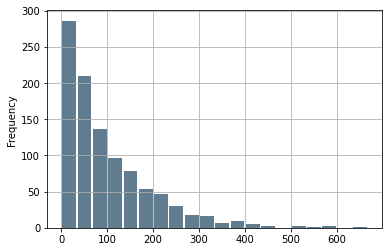

In [20]:
import numpy as np
import pandas as pd

def plot_gaps(r):
    r.sort()
    gaps = pd.Series(np.diff(r))
    gaps.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
data = list(range(100000))
n = len(data)
k = 1000
r = reservoirSample(data, n, k)
plot_gaps(r)

- Turns out this is approximately a geometric distribution with a closed form!
  - Won't prove here
- So we can pick random gaps from geometric distribution
  - "skip over" the to-be-discarded inputs in between
  - only call RNG as many times as there are gaps!
  - i.e. about as many times as the size of the sample!

In [21]:
# This is called Algorithm L
# ported from https://en.wikipedia.org/wiki/Reservoir_sampling
from random import random, randrange
from math import exp, log, floor

def reservoirSampleL(data, n, k):
  # fill the reservoir array
  r = []
  for i in range(k):
    r.append(data[i])
    
  # random.random() generates a uniform [0,1) random number
  w = exp(log(random())/k)

  while i < n:
      i = i + floor(log(random())/log(1-w)) + 1
      if i < n:
          # replace a random item of the reservoir with item i
          r[randrange(k)] = data[i]  # random index between 0 and k-1, inclusive
          w = w * exp(log(random())/k)
            
  return(r)
     
data = list(range(1000))
n = len(data)
k = 5
r = reservoirSampleL(data, n, k)
r

[707, 912, 910, 874, 560]

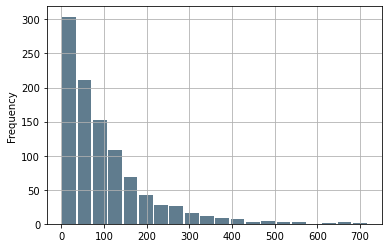

In [22]:
data = list(range(100000))
n = len(data)
k = 1000
r = reservoirSampleL(data, n, k)
plot_gaps(r)

### Reservoir Sampling as a Table-Valued UDF in PostgreSQL
We can implement a reservoir as a table function that returns (rownumber, pos) pairs and join with that to sample.

In [24]:
## replace the database connection with a database of your own!
%reload_ext sql
%sql postgresql://jmh@localhost:5432/baseball

In [25]:
%%sql
DROP TYPE IF EXISTS reservoir_pair CASCADE;
CREATE TYPE reservoir_pair AS (rownum integer, pos integer);
CREATE OR REPLACE FUNCTION reservoir_swaps(k integer, n integer) RETURNS setof reservoir_pair
    AS $$

  from random import random, randrange
  from math import exp, log, floor
  # fill the reservoir array
  r = []

  for i in range(k):
    yield((i,i))
    
  # random.random() generates a uniform [0,1) random number
  w = exp(log(random())/k)

  while i < n:
      i = i + floor(log(random())/log(1-w)) + 1
      if i < n:
          # replace a random item of the reservoir with item i
          w = w * exp(log(random())/k)
          yield(i, randrange(k))  # random index between 0 and k-1, inclusive
            
  return(r)
    $$
    LANGUAGE 'plpython3u'
    VOLATILE
    RETURNS NULL ON NULL INPUT;
CREATE OR REPLACE FUNCTION reservoir_rows(k integer, n integer) RETURNS setof integer
  AS $$ SELECT MAX(rownum) AS rownum FROM reservoir_swaps(k, n) GROUP by pos $$ 
LANGUAGE 'sql'
VOLATILE;

 * postgresql://jmh@localhost:5432/baseball
Done.
Done.
Done.
Done.


[]

In [26]:
%%sql
WITH rrows AS (SELECT reservoir_rows(10, count(*)::integer) AS rows 
                 FROM batting),
     rbatting AS (SELECT row_number() over(), * 
                    FROM batting)
SELECT *
  FROM rbatting, rrows 
 WHERE row_number = rows;

 * postgresql://jmh@localhost:5432/baseball
10 rows affected.


row_number,playerid,yearid,stint,teamid,lgid,g,ab,r,h,h2b,h3b,hr,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp,rows
3061,stemmbi01,1885,1,BSN,NL,2,7,1,3,1,0,0,2,None,None,0,0,None,None,None,None,None,3061
15592,johnsch02,1915,1,KCF,FL,46,87,2,11,2,0,1,8,2,None,6,39,None,2,4,None,None,15592
17725,dowdsn01,1919,1,DET,AL,1,0,0,0,0,0,0,0,0,None,0,0,None,0,0,None,None,17725
19885,grantge01,1923,1,CHN,NL,152,570,81,160,36,8,8,70,43,28,71,92,None,0,24,None,None,19885
47470,donaljo01,1969,1,OAK,AL,12,13,1,1,0,0,0,0,0,0,2,4,1,0,0,0,0,47470
49509,johnsbo03,1971,1,PIT,NL,31,48,3,3,0,0,0,2,0,0,8,33,0,0,4,0,2,49509
50233,fitzmal01,1972,1,KCA,AL,39,23,1,4,0,0,0,0,0,0,4,3,0,0,0,0,1,50233
81828,taubeed01,2001,1,CLE,AL,52,116,16,29,2,1,3,11,0,0,10,19,1,1,1,0,3,81828
96941,victosh01,2012,2,LAN,NL,53,208,26,51,12,2,2,15,15,2,18,31,0,4,4,1,1,96941
98709,craigal01,2014,2,BOS,AL,29,94,7,12,3,0,1,2,1,0,9,36,0,4,0,0,3,98709


## Stratified Sampling
We often want to do what's called *stratified sampling*.

- SQL folks might call it GROUP BY sampling
  - i.e. I want a $k$-sized sample per GROUP
  - the "GROUP BY" columns are called "subpopulations"
- PostgreSQL's Bernoulli tablesamples do not support stratification
  - the sample happens on the initial scan
- But our reservoir implementation works with GROUP BY!

In [27]:
%%sql
-- Stratified Sampling with Reservoirs
WITH grprows AS (SELECT teamid, reservoir_rows(10, COUNT(*)::integer) AS rows 
                   FROM batting 
                  GROUP BY teamid),
     rbatting AS (SELECT row_number() over(partition by teamid), * 
                    FROM batting)
SELECT *
  FROM rbatting b, grprows g
 WHERE row_number = rows
   AND b.teamid = g.teamid
 ORDER BY b.teamid;

 * postgresql://jmh@localhost:5432/baseball
1450 rows affected.


row_number,playerid,yearid,stint,teamid,lgid,g,ab,r,h,h2b,h3b,hr,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp,teamid_1,rows
1,shafff01,1884,1,ALT,UA,6,19,1,3,0,0,0,None,None,None,0,None,None,None,None,None,None,ALT,1
2,carropa01,1884,1,ALT,UA,11,49,4,13,1,0,0,None,None,None,1,None,None,None,None,None,None,ALT,2
4,murphjo01,1884,1,ALT,UA,23,94,10,14,1,0,0,None,None,None,4,None,None,None,None,None,None,ALT,4
6,crosscl01,1884,1,ALT,UA,2,7,1,4,1,0,0,None,None,None,2,None,None,None,None,None,None,ALT,6
7,harrifr01,1884,1,ALT,UA,24,95,10,25,2,1,0,None,None,None,3,None,None,None,None,None,None,ALT,7
8,connojo01,1884,1,ALT,UA,3,11,0,1,0,0,0,None,None,None,0,None,None,None,None,None,None,ALT,8
12,brownji01,1884,1,ALT,UA,21,88,12,22,2,2,1,None,None,None,1,None,None,None,None,None,None,ALT,12
14,mooreje01,1884,1,ALT,UA,20,80,10,25,3,1,1,None,None,None,0,None,None,None,None,None,None,ALT,14
15,smithge01,1884,1,ALT,UA,25,108,9,34,8,1,0,None,None,None,1,None,None,None,None,None,None,ALT,15
17,shaffta01,1884,1,ALT,UA,13,55,10,18,2,0,0,None,None,None,3,None,None,None,None,None,None,ALT,17


### Materialized Samples
- We can use `CREATE TABLE AS SELECT ...` to put a sample into a table. 
- Then we can reuse the sample at will
  - E.g. load it onto our desktop and even use Pandas instead of SQL.

### Concerns with Materialized Samples
1. Be sure to normalize estimators appropriately
     - e.g. multiply COUNT or SUM by sampling rate
2. There will be uncertainty in these estimators
     - sometimes stats offers a *confidence interval* on estimators
       - e.g. "with probability $p$ the true value equals the estimate +- $\epsilon$"
     - depends on the query structure
     - Resampling (bootstrap) can give you a sense of the C.I.

### Concerns with Materialized Samples, Cont.
3. If you reuse the sample for many different estimators, you will eventually be biased.
     - Resampling from the sample can help
     - Periodically refresh the sample from the DB
4. You **need to validate on the full dataset**
     - After exploratory work, run the pipeline on the full data!
     - Best to do your "desktop" work in a scalable language.

# Notes on Samples and SQL
Do not join table samples!

```
SELECT SUM(E.salary / D.budget) 
  FROM employees E NATURAL JOIN departments D
```
- We'd like to estimate this value on $sample(E \bowtie D)$
- *Sad Fact*: $sample(E \bowtie D) \ne (sample(E) \bowtie sample(D)) $!
  - TABLESAMPLE with JOIN gives nonsense in the SUM!
- *Worse Fact*: the join of two table samples is often empty!! 
  - Think about odds of an employee's dept being in sample!

## Notes on Samples and SQL, cont.
- There is research in the area of *Approximate Query Processing*
  - not common in shipping database systems.
- More complex SQL also messes up sampling/estimators
  - Window queries, subqueries, etc.
- Pragmatic strategy
  1. Play with reservoir samples of query outputs as CTEs/Views/CTAS
  2. *Don't* do complicated SQL with the sample 
    - No join, window, subquery, etc.
    - Instead:
      - do the complicated SQL on the full tables
      - goto (1)

## Two Very Useful Sketches
  - *CountMin* sketches for `SELECT COUNT(*) ... WHERE col = k`
    - Also `WHERE col BETWEEN k AND l`
  - *HyperLogLog* sketches for `SELECT COUNT(DISTINCT col)`

## Inuition for CountMin Sketch
`SELECT COUNT(*) ... WHERE col = x`

Incredibly simple idea!

Intuition:
- Pick a hash function $h$ that maps the data type of `col` to integers
- Create an array $A$ of $b$ counters
- For each value $v$ in `col`, increment the counter at $A[{h(v)}]$
- To compute the count of rows `WHERE col = x` return $A[{h(x)}]$

How bad is our estimate?
- Could be *too high*, due to hash "collisions" (never too low!)
- If we collide with key $y \ne x$, we return the sum of their frequencies
  - $A[{h(x)}] = f_x + \sum_{y \in S}f_y \hspace{2em}$ where $S = {y \ne x : h_i(y) = h_i(x)}$
  - We expect $x$ to collide with $1/b$ of the values in our data
  - So we expect $A[{h(x)}] = f_x + \frac{1}{b}\sum_{y \ne x}f_y \le f_x + \frac{n}{b}$
    - after all, the sum of all frequencies is $n$
  - If we want to bound our overestimate by $\epsilon f_x$, just choose $b = 1/\epsilon$.
  - Note this has no dependence on $n$, the size of our dataset: scales great!
  
Why not stop here?
  - We got the expected error to an $\epsilon$ factor!
  - But the *variance* in the error can be high
    - some buckets will be "unlucky"!
    - We want the probability that the error is bigger than $\epsilon$ to be $\delta$.
  - So let's use the idea of independent samples to help.

## CountMin Sketch
- Repeat the idea above with $l$ pairwise-independent hash functions.
  - Easy to parameterize these from a "family"
  - The CountMin Sketch is an array of $l$ rows and $b$ columns
    - each row "belongs" to one of the hash functions
<img src="files/countMin.png" height=1in>
- Insertion
  - For each value $v$ in the input, for each hash function $l$, increment $h_l(v)$
- To compute the count of key $x$, look up all $l$ values $h_l(x)$
  - Each is an overestimate...
  - So return the minimum: $\min_{i=0}^l A_i[x]$!
- With some more work, you can show that we want $l = \log_2 \frac{1}{\delta}$ 
  - bounds the probability of exceeding $\epsilon$ at $\delta$
  - google for the math or take Prof. Nelson's class!

## CountMin Sketches in Practice
- Easy to write
  - You can find lots of reference implementations online in Java, C++, Python, etc.
  - PostgreSQL has a package called [Apache MADLib](https://madlib.apache.org/) that provides [CountMin sketches](http://madlib.apache.org/docs/latest/group__grp__countmin.html) and lots of Stat/ML routines in SQL
- Scales to arbitrarily large data sets!
- In practice, all the hashing at construction time can be slow
  - Needs to be paid off by many queries
  - Parallelizes trivially though!
  
- PostgreSQL/MADlib example below
  - [MADlib CMsketch](https://github.com/apache/madlib/blob/4987e8fe5367bb823afb1bd4020fd6f0fa603258/methods/sketch/src/pg_gp/countmin.h) is set to $l = 8, b = 1024$. With 64-bit integers this is just 64 KB!
    - $\epsilon = 2/b = .002$
    - $\delta = \frac{1}{2}^l = .004$ (i.e., $99.6\%$ probability within $\epsilon n$!)

In [ ]:
## MADlib is only compatible with PostgreSQL 12
## My PostgreSQL 12 installation didn't have Python3
## So let's switch connections now
%reload_ext sql
%sql postgresql://jmh@localhost:5433/baseball

In [ ]:
%%sql
WITH data AS (SELECT floor(random()*10)::integer AS class, 
                     floor(exp(log(random()*100)))::integer AS a1 FROM generate_series(1,100000)),
     sketch AS (SELECT madlib.cmsketch(class) AS class_cm, madlib.cmsketch(a1) AS a1_cm FROM data)
SELECT 'sketch' as method, 
       madlib.cmsketch_count(class_cm, 7) as class_7, madlib.cmsketch_count(class_cm, 9) as class_9, 
       madlib.cmsketch_count(a1_cm, 3) as a1_3, madlib.cmsketch_count(a1_cm, 7) as a1_7
  FROM sketch
UNION ALL
SELECT 'actual', 
       sum(CASE WHEN class = 7 THEN 1 ELSE 0 END), sum(CASE WHEN class = 9 THEN 1 ELSE 0 END),
       sum(CASE WHEN a1 = 3 THEN 1 ELSE 0 END), sum(CASE WHEN a1 = 7 THEN 1 ELSE 0 END)
  FROM data;

In [ ]:
%%sql
WITH sketch AS (SELECT madlib.cmsketch(hr) AS hr_cm FROM batting)
SELECT 'sketch' as method, 
       madlib.cmsketch_count(hr_cm, 40)
  FROM sketch
UNION ALL
SELECT 'actual', 
       COUNT(*)
  FROM batting
 WHERE hr = 40;

## HyperLogLog Sketch
`SELECT COUNT(DISTINCT col) FROM table`

Problem:
- Imagine you've seen 1 billion distinct values so far
  - Originally studied to classify network packet streams at line rate
  - How many unique source/destination pairs have we seen?
- To see if a new row has a new value, we need to remember the previous 1 billion!
- Can we do this in a small amount of space?

HyperLogLog is one of many solutions to this problem.
- Jelani Nelson is a co-author on [the first asymptotically space- and time-optimal algorithm](https://dash.harvard.edu/bitstream/handle/1/13820438/f0.pdf) for this problem.
- Recently [completely resolved the asymptotic space complexity](http://people.eecs.berkeley.edu/~minilek/publications/papers/approx_count.pdf) of this problem!

## HyperLogLog Intuition
- For each value $v$ we see, compute a hash $h(v)$
  - Generates a number chosen uniformly at random between 0 and $\infty$
  - How many leading 0's on the left do we expect?

In [ ]:
# https://www.geeksforgeeks.org/number-of-leading-zeros-in-binary-representation-of-a-given-number/
def countZeros(x): 
    # Keep shifting x by one until 
    # leftmost bit does not become 1.
    total_bits = 32
    res = 0
    while ((x & (1 << (total_bits - 1))) == 0):
        x = (x << 1)
        res += 1
  
    return res


from random import randint
import pandas as pd
s = pd.Series([countZeros(hash(i)) for i in range(1,1000)])
s.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')

Run the cell above a few times and you'll see:
- About 1/2 the values have no leading zeros. Makes sense!
    - These are random bit strings, so odds that first bit is `1` is $50\%$
- Decays by a factor of 2 for each bar to the right. Makes sense!
    - Odds that the first 2 bits are `10` is $25\%$. Etc.
- Continuing to divide by 2, we expect the rightmost non-zero bar to be at $\rho = log_2(n) - 1$ 
  - Where $n$ is the total number of values
  - But note: adding *duplicate* values raises all bars but doesn't add any new bars to the right!
  - So $2^{\rho + 1}$ is a good estimator of `COUNT(DISTINCT)`!!
- But ... lots of variance across trials.
- HyperLogLog breaks the input into subsets and uses the harmonic mean of the resulting estimates

### HyperLogLog in Practice
- With $m$ bytes of memory gives accuracy of $1.04/\sqrt{m}$
  - E.g. $2%$ accuracy with 1.5KB of memory
- You can find lots of implementations online
- Apache MADlib has an older sketch from the same lead author (P. Flajolet) called an [FM sketch](http://madlib.apache.org/docs/latest/group__grp__fmsketch.html)

In [ ]:
%%sql
WITH data AS (SELECT floor(random()*10)::integer AS class, 
                     floor(exp(log(random()*100)))::integer AS a1 FROM generate_series(1,100000)),
     approx AS (SELECT madlib.fmsketch_dcount(class) AS class_fm, madlib.fmsketch_dcount(a1) AS a1_fm FROM data)
SELECT 'sketch' as method, 
       *
  FROM approx
UNION ALL
SELECT 'actual', 
       COUNT(DISTINCT class), COUNT(DISTINCT a1)
  FROM data;

## More on Sketching
Sketches are like materialized views that can approximate the answer to a class of queries.
- Like Materialized views, they take time to build, and need to be kept "fresh"
  - But they're typically *tiny* and insensitive to input size, which is very cool
  - Can pass them around for all kinds of tricks: e.g. ship to apps in browser or phone, etc.
- Sketches typically work as streaming algorithms, which is nice
  - Most support incremental additions
  - Some support deletions
- Many can be computed in parallel

## More on Sketching, cont.

- There are more sketch types and variants to handle more classes of queries
  - "Heavy Hitter" queries (return the top k most popular values in the stream)
  - Exists queries (the earliest sketch: Bloom Filters)
  - Count-Range queries
  - Histograms
  - Approximate data cubes
  - Etc.


Sketches are mostly used in high-volume streaming settings
  - The approximation/performance tradeoffs has to be acceptable
  - You need to have a need to do LOTS of queries on the sketch to amortize cost of hashing
  - Not typically supported in database systems even today

# Additional Resources
- Prof. Nelson's [graduate course at Berkeley](https://www.sketchingbigdata.org/fall20/)
- Book: Cormode/Garofalakis/Haas/Jermaine [Synopses for Massive Data: Samples, Histograms, Wavelets, Sketches](https://db.cs.berkeley.edu/cs286/papers/synopses-fntdb2012.pdf)

# Material below is scratch

In [ ]:
%%sql
-- For reference, Reservoir sampling in PL/PGSQL
DROP TYPE IF EXISTS reservoir_pair CASCADE;
CREATE TYPE reservoir_pair AS (rownum integer, pos integer);
CREATE OR REPLACE FUNCTION reservoir_swaps(integer, integer) RETURNS setof reservoir_pair
    AS $$
       DECLARE 
        w float;
        k alias for $1;
        n alias for $2;
        i integer;
        retval integer := NULL;
       BEGIN
       w := exp(log(random())/k::float);
            
       FOR i IN 0..k LOOP
         RETURN NEXT ROW(i, i);
       END LOOP;
    
       i := k;
        
       WHILE i < n LOOP
         i := i + floor(log(random())/log(1-w)) + 1;
         IF i < n THEN
           w := w * exp(log(random())/k);
           RETURN NEXT ROW(i, floor(random()*k)::integer);
         END IF;
       END LOOP;
       END;
    $$
    LANGUAGE 'plpgsql'
    VOLATILE
    RETURNS NULL ON NULL INPUT;
CREATE OR REPLACE FUNCTION reservoir_rows(k integer, n integer) RETURNS setof integer
  AS $$ SELECT MAX(rownum) AS rownum FROM reservoir_swaps(k, n) GROUP by pos $$ 
LANGUAGE 'sql'
VOLATILE;